In [41]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm
from models import *
from scipy.spatial.distance import cosine
from utils.CKA import *
import math

In [44]:
PATH = "model_checkpoints/dirichlet-cifar10/simpleNet4/100(100)clients/"
simplenetv4_simpletanh = torch.load(PATH+"100_100 *1.0_5_100_0.01_0.9_sgd_0.005_ce_{'num_filter': '16', 'activation': 'simple_tanh'}_0.0001/epoch=100.t1")
simplenetv4_relu = torch.load(PATH+"100_100 *1.0_5_100_0.01_0.9_sgd_0.005_ce_{'num_filter': '16', 'activation': 'relu'}_0.0001/epoch=100.t1")

In [45]:
simplenetv4_simpletanh.keys()

dict_keys(['client', 'server'])

In [46]:
stanh_client_models = [0] * 21
relu_client_models = [0] * 21
for i in tqdm(range(21)):
    if i < 20:
        stanh_client_models[i] = simpleNet4(num_classes=10, num_filter=16, activation='simple_tanh')
        stanh_client_models[i].load_state_dict(simplenetv4_simpletanh['client'][i])
        stanh_client_models[i].eval()

        relu_client_models[i] = simpleNet4(num_classes=10, num_filter=16, activation='relu')
        relu_client_models[i].load_state_dict(simplenetv4_relu['client'][i])
        relu_client_models[i].eval()    
    else:
        stanh_client_models[i] = simpleNet4(num_classes=10, num_filter=16, activation='simple_tanh')
        stanh_client_models[i].load_state_dict(simplenetv4_simpletanh['server'])
        stanh_client_models[i].eval()

        relu_client_models[i] = simpleNet4(num_classes=10, num_filter=16, activation='relu')
        relu_client_models[i].load_state_dict(simplenetv4_relu['server'])
        relu_client_models[i].eval()    

100%|██████████| 21/21 [00:00<00:00, 220.02it/s]


In [47]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

testset = torchvision.datasets.CIFAR10(root='./data/dirichlet-cifar10/', train=False, download=True, transform=transform)

Files already downloaded and verified


In [48]:
def get_feature(x, model):
    features = {}
    for _, (name, layer) in enumerate(model.named_children()):
        if "Cross" in str(layer):
            break
        elif "Linear" in str(layer):
            x = torch.flatten(x,1)
        x = layer(x)
        if "Conv" in str(layer):
            x = model.activation(x)
        features[str(name)] = x
    return features

In [49]:
test_image = {}
for image in testset:
    image_class = image[1]
    if image_class not in test_image:
        test_image[image_class] = image[0].unsqueeze(0)
    else:
        test_image[image_class] = torch.cat([test_image[image_class], image[0].unsqueeze(0)], dim=0)

# Feature Extract

In [50]:
stanh_class_feature = [0] * 21
for i in tqdm(range(21)):
    stanh_class_feature[i] = [0] * 10
    for j in range(10):
        stanh_class_feature[i][j] = get_feature(test_image[j][500:530], stanh_client_models[i])
        
relu_class_feature = [0] * 21
for i in tqdm(range(21)):
    relu_class_feature[i] = [0] * 10
    for j in range(10):
        relu_class_feature[i][j] = get_feature(test_image[j][500:530], relu_client_models[i])

100%|██████████| 21/21 [00:03<00:00,  6.59it/s]


# Client별 CKA

In [106]:
relu_CKA = np.zeros((20,20))
stanh_CKA = np.zeros((20,20))
for i in tqdm(range(20)):
    for j in range(20):
        relu_CKA[i,j] = linear_CKA(np.mean(relu_class_feature[i][0]['maxpool'].detach().numpy(), axis=(1,2)), np.mean(relu_class_feature[j][0]['maxpool'].detach().numpy(), axis=(1,2)))
        stanh_CKA[i,j] = linear_CKA(np.mean(stanh_class_feature[i][0]['maxpool'].detach().numpy(), axis=(1,2)), np.mean(stanh_class_feature[j][0]['maxpool'].detach().numpy(), axis=(1,2)))

100%|██████████| 20/20 [00:00<00:00, 24.12it/s]


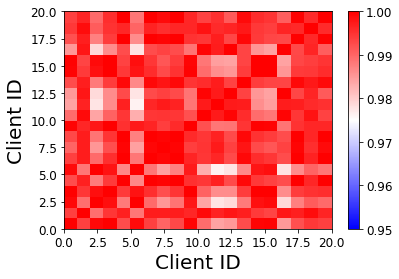

In [107]:
plt.pcolor(relu_CKA, cmap='bwr')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
plt.clim(0.95, 1)
plt.ylabel('Client ID',fontsize=20)
plt.xlabel('Client ID', fontsize=20)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.savefig('./fig/client=100_epoch=100_relu_maxpool_client vs client.pdf', bbox_inches='tight')

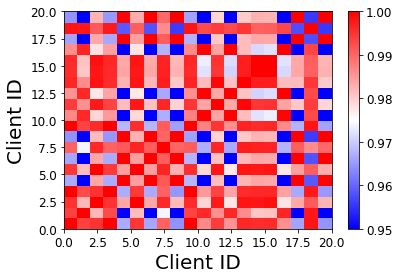

In [108]:
plt.pcolor(stanh_CKA, cmap='bwr')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
plt.clim(0.95, 1)
plt.ylabel('Client ID', fontsize=20)
plt.xlabel('Client ID', fontsize=20)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.savefig('./fig/client=100_epoch=100_hardtanh_maxpool_client vs client.pdf',bbox_inches='tight')

# CKA per CLASS

In [49]:
relu_class_CKA = np.zeros((20,10))
stanh_class_CKA = np.zeros((20,10))
for i in tqdm(range(20)):
    for j in range(10):
        relu_class_CKA[i,j] = linear_CKA(np.mean(relu_class_feature[i][j]['maxpool'].detach().numpy(), axis=(1,2)), np.mean(relu_class_feature[20][j]['maxpool'].detach().numpy(), axis=(1,2)))
        stanh_class_CKA[i,j] = linear_CKA(np.mean(stanh_class_feature[i][j]['maxpool'].detach().numpy(), axis=(1,2)), np.mean(stanh_class_feature[20][j]['maxpool'].detach().numpy(), axis=(1,2)))

100%|██████████| 20/20 [00:00<00:00, 41.94it/s]


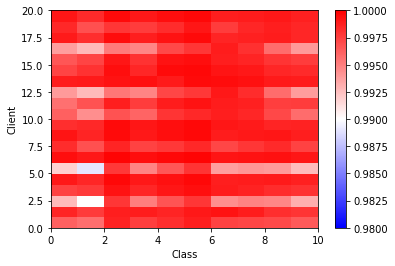

In [55]:
plt.pcolor(relu_class_CKA, cmap='bwr')
plt.colorbar()
plt.xlabel('Class')
plt.ylabel('Client')
plt.clim(0.98, 1)
plt.savefig('./fig/client=100_epoch=100_relu_maxpool_server vs client.pdf')

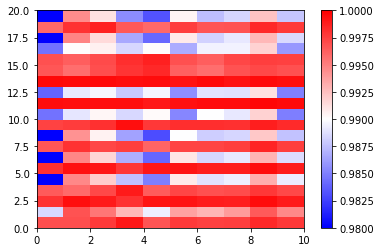

In [54]:
plt.pcolor(stanh_class_CKA, cmap='bwr')
plt.colorbar()
plt.clim(0.98, 1)
plt.savefig('./fig/client=100_epoch=100_hardtanh_maxpool_server vs client.pdf')